# Notebook for training computer vision models for BugID

## Load libraries and data

In [ ]:
#Load libraries and constants
import timm
from fastai.vision.all import *
import pandas as pd
from torchvision import transforms
import torch
import cv2
import numpy as np
import shap
import torchvision

image_dir = Path("image_preproc")
model_dir = Path("models")
data_dir = Path("data")

img_size = 300

In [2]:
#Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) # if p.requires_grad

In [3]:
#Function to preproces images using opencv
def img_preproc(path):
    image = cv2.imread(path)
    preproc = cv2.dnn.blobFromImage(image = image, 
                                    scalefactor = 1/255, 
                                    size = (img_size, img_size), 
                                    swapRB=True, 
                                    crop=True)
    
    return preproc

In [4]:
#Calculate weigths per class because of imbalanced data distribution
targets = [parent_label(i) for i in get_image_files(image_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]
n_classes = len(count)

In [5]:
#Define dataloaders
bs = 32

block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.3, flip_vert=True),
                  get_y = parent_label)
    
loaders = block.weighted_dataloaders(image_dir, wgts=wgts, bs=bs)

In [5]:
#Write model vocabolary to file
vocab = loaders.vocab

with open(data_dir/"vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

## Benchmark models

In [6]:
#List learners to benchmark
learners = ["resnet18", "resnet34", "resnet50", 
            "mobilenetv2_050", "mobilenetv2_100", "mobilenetv2_140",
            "convnext_nano", "convnext_tiny"]

In [ ]:
#Iterate over all learners and obtain validation statistics
results = []

for name in learners:
    
    #Define learner
    learn = vision_learner(loaders, 
                           name,
                           pretrained=True,
                           normalize=True,
                           loss_func=LabelSmoothingCrossEntropy(),
                           metrics=[accuracy, top_k_accuracy],
                           cbs=SaveModelCallback(fname=name)).to_fp16()

    #Fine-tune learner
    learn.fine_tune(epochs=15, freeze_epochs=3)

    #Count parameters
    n_params = count_parameters(learn)

    #Get validation set metrics
    preds, targets = learn.get_preds()

    val_acc = accuracy(preds, targets)
    val_top5 = top_k_accuracy(preds, targets)
    
    results.append({"model": name, "val_acc": val_acc.item(), "val_top5": val_top5.item(), "n_params": n_params})

In [18]:
#Export benchmark results
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir/"benchmark.csv", index=False)

## Inspect models 

In [7]:
#Load learner for inspection and export
model_name = "convnext_nano"

learn = vision_learner(loaders, 
                       model_name,
                       pretrained=True,
                       normalize=True).load(model_name)


Saved filed doesn't contain an optimizer state.


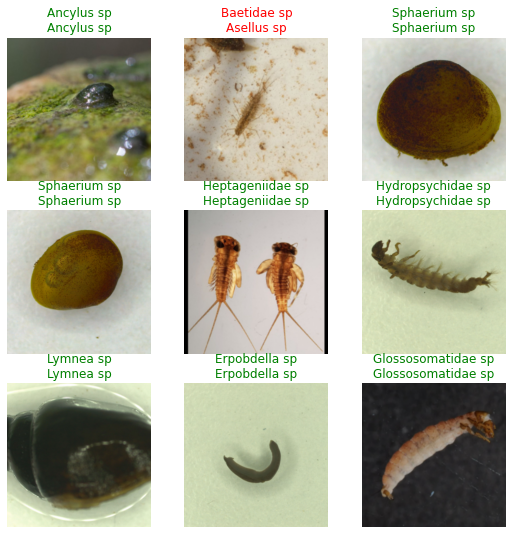

In [8]:
#Show example predictions
learn.show_results()

In [9]:
#Create confusion matrix
interpreter = ClassificationInterpretation.from_learner(learn)

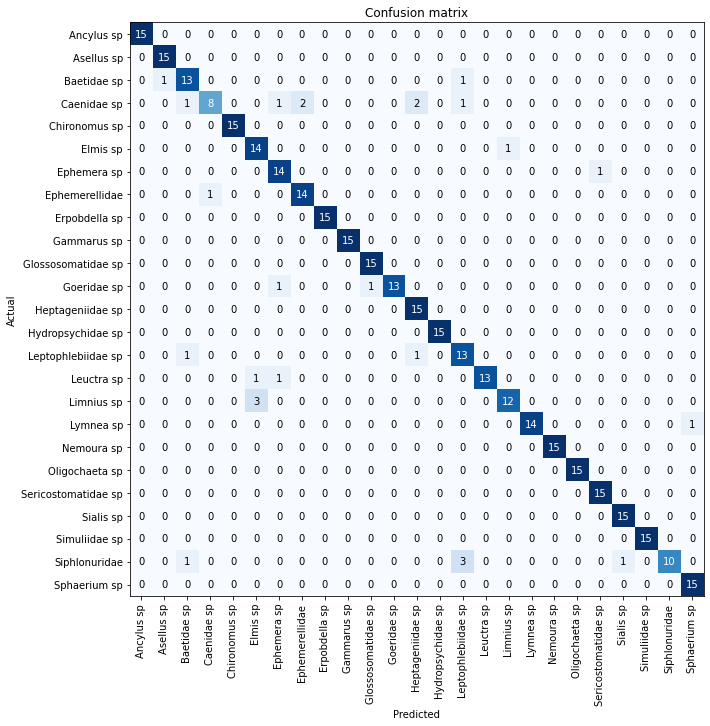

In [10]:
interpreter.plot_confusion_matrix(figsize=(10,10))

## Export models to ONNX format

In [11]:
#Define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#Define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#Assemble the final model
onnx_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)
onnx_model.eval()

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
                (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
                  (act): GELU()
                  (drop1): Dropout(p=0.0, inplace=False)
                  (norm): Identity()
                  (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
                  (drop2): 

In [11]:
#Generate model sample input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/f"{model_name}.onnx"

In [12]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#Model export into ONNX format
torch.onnx.export(
    onnx_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Test fastai and ONNX model predictions

In [13]:
#Test fastai and ONNX model predictions
image_sample = "image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png"

In [14]:
#Get fastai predictions for sample image
spec, idx, probs = learn.predict(image_sample)

In [15]:
#Load ONNX model using opencv
model = cv2.dnn.readNetFromONNX(f"models/{model_name}.onnx")

In [16]:
#Preprocess sample image using opencv (similar to GUI)
model_input = img_preproc(image_sample)

In [17]:
#Get ONNX model predictions
model.setInput(model_input)
probs_onnx = model.forward().squeeze()

In [18]:
probs_onnx, probs.numpy()

(array([2.3083619e-03, 9.2065763e-01, 5.8107864e-04, 4.0610568e-03,
        2.3187485e-03, 6.5948390e-03, 7.8800262e-04, 1.4424482e-03,
        3.0404367e-03, 1.1304687e-02, 1.2979949e-03, 3.6845184e-03,
        1.2025620e-03, 3.2048381e-03, 3.9071264e-04, 4.8711961e-03,
        2.1368258e-03, 2.4587093e-03, 2.2930349e-03, 2.2373155e-03,
        3.5093972e-03, 1.0730162e-02, 1.7481861e-03, 3.3497233e-03,
        3.7875238e-03], dtype=float32),
 array([1.0834065e-03, 9.6167344e-01, 3.2505573e-04, 2.0606818e-03,
        1.1313492e-03, 3.0834784e-03, 3.3985754e-04, 7.8537187e-04,
        1.5964077e-03, 6.6239787e-03, 7.2213047e-04, 1.9442525e-03,
        5.6345476e-04, 1.0570571e-03, 2.1280341e-04, 2.1971972e-03,
        1.0461808e-03, 1.4970399e-03, 1.0500876e-03, 1.0937245e-03,
        1.2470942e-03, 4.6010669e-03, 7.9464400e-04, 1.5248683e-03,
        1.7454615e-03], dtype=float32))

## Perform SHAP interpretation

In [12]:
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

shap_model = nn.Sequential(normalization_layer, torch_model)

shap_model.eval()
shap_model.to(device)


Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
                (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
                  (act): GELU()
                  (drop1): Dropout(p=0.0, inplace=False)
                  (norm): Identity()
                  (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
                  (drop2): 

In [13]:
class_names = learn.dls.vocab
class_names = [i.replace(" sp", "") for i in class_names]

#Function for predicting label from image
def predict(img):
    
    img = torch.Tensor(img)
    
    if img.dim() == 3:
        img = img.unsqueeze(0)
    
    img = img.transpose(3, 1)
    img = img.to(device)
    
    with torch.no_grad():  
        output = shap_model(img)
        
    return output


In [14]:
imgs_list = ["image_preproc/valid/Hydropsychidae sp/CPH-Hydropsychidae sp.-2043.png",
             "image_preproc/valid/Nemoura sp/CPH-Nemoura sp.-2328.png"]

X = np.stack([img_preproc(i) for i in imgs_list])
X = torch.Tensor(X.squeeze().transpose((0, 2, 3, 1)))

In [15]:
y_hat = predict(X)
print(torch.nn.Softmax(dim=1)(y_hat))

classes = torch.argmax(y_hat, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

tensor([[3.2381e-03, 1.3959e-02, 1.5487e-02, 1.1802e-03, 3.9852e-03, 4.4364e-03,
         1.9543e-03, 2.6210e-02, 2.0877e-03, 4.2736e-03, 5.3765e-03, 1.9374e-03,
         4.7540e-04, 8.6192e-01, 8.2307e-03, 1.2053e-02, 2.3445e-03, 2.6440e-03,
         6.8872e-04, 3.3004e-03, 3.5985e-03, 5.1398e-03, 1.1160e-02, 1.1249e-03,
         3.1921e-03],
        [6.9123e-03, 2.4512e-03, 1.9507e-03, 5.8802e-03, 7.7737e-03, 2.5913e-03,
         3.1221e-03, 9.4376e-03, 3.4068e-03, 1.3282e-03, 1.5813e-03, 3.1354e-03,
         6.2768e-03, 1.2235e-02, 3.9397e-03, 4.1737e-03, 5.4185e-03, 3.9775e-03,
         8.8523e-01, 4.7590e-03, 3.9479e-03, 2.5265e-03, 8.6624e-03, 2.6808e-03,
         6.6057e-03]], device='cuda:0')
Classes: [13 18]: ['Hydropsychidae' 'Nemoura']


In [25]:
topk = 3
batch_size = 100
n_evals = 5000

masker_blur = shap.maskers.Image("blur(150,150)", X[0].shape)

explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  50%|████████████████                | 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 3it [00:47, 23.96s/it]                                     


In [26]:
shap_values.data = shap_values.data.cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]

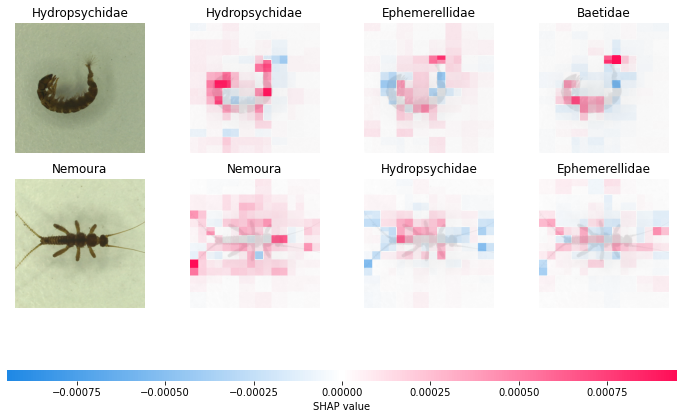

In [31]:
plt.rcParams["figure.facecolor"] = "w"

shap.image_plot(shap_values=shap_values.values, pixel_values=shap_values.data,
                              labels=shap_values.output_names, show=False, 
                              true_labels = ["Hydropsychidae", "Nemoura"])

plt.savefig('figures/figure_5.jpg', bbox_inches='tight', dpi=300)
